### Testing downsampling to eboss log-10 wavelength grid

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy
import specsim.simulator

#### To do:
• need to handle n > 1 fibers

In [3]:
# Our simulation grid is defined at the top of the config file
print(np.arange(3000, 10050.01, 0.1).shape)

(70501,)


In [4]:
simulator = specsim.simulator.Simulator('eboss', num_fibers=1)
simulator.atmosphere
#simulator.instrument.fast_fiber_acceptance
simulator.simulate()

blue_output = simulator.camera_output[0]
red_output = simulator.camera_output[1]

sim = simulator.simulated

b_wlen, r_wlen = blue_output['wavelength'], red_output['wavelength']
b_flux, r_flux = blue_output['observed_flux'], red_output['observed_flux']

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


In [5]:
eboss_b_output = simulator.camera_output[2]
eboss_r_output = simulator.camera_output[3]

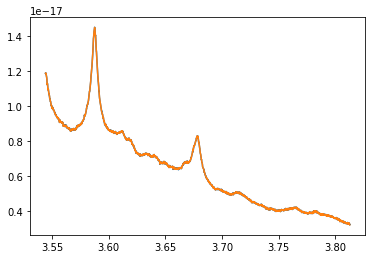

In [6]:
plt.plot(np.log10(b_wlen), b_flux)
plt.plot(eboss_b_output['wavelength'], eboss_b_output['observed_flux'])
plt.show()

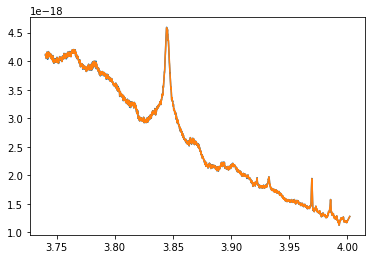

In [7]:
plt.plot(np.log10(r_wlen), r_flux)
plt.plot(eboss_r_output['wavelength'], eboss_r_output['observed_flux'])
plt.show()

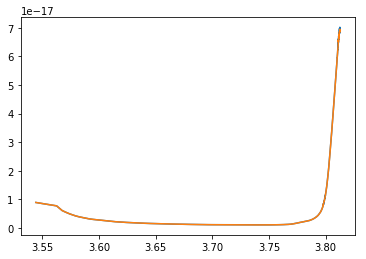

In [8]:
plt.plot(np.log10(b_wlen), blue_output['flux_calibration'])
plt.plot(eboss_b_output['wavelength'], eboss_b_output['flux_calibration'])
plt.show()

In [9]:
def downsample_to_eboss(wave_out, wave_in, data):
    
    ## Get nominal bin width
    diff_in = np.diff(wave_in)
    ## Check that nominal grid is equally spaced 
    assert np.allclose(diff_in[0], diff_in, atol=0.0, rtol=1e-5)
    diff_in = diff_in[0]
    
    ## Define nominal bin edges
    edges_in = wave_in - (0.5 * diff_in)
    edges_in = np.append(edges_in, edges_in[-1] + diff_in)
    edges_in = np.log10(edges_in)
    
    ## Define output bin edges
    diff_out = np.diff(wave_out)
    diff_out = np.append(diff_out, diff_out[-1])
    edges_out = wave_out - (0.5 * diff_out)
    edges_out = np.append(edges_out, edges_out[-1] + diff_out[-1])
    #edges_out = edges_out[::10]
        
    ## Check that both grids are strictly increasing
    assert np.all(edges_out == np.sort(edges_out))
    assert np.all(edges_in == np.sort(edges_in))
    ## Check that output grid covers the range of input grid 
    ## This is a necessary condition for flux conservation.
    assert edges_out[0] < edges_in[0]
    assert edges_out[-1] > edges_in[-1]
        
    ## Find index in out_edges where each element in in_edges 
    ## would fall in out_edges
    idx_in_out = np.searchsorted(edges_out, edges_in)
        
    ## Convert from density (per unit Angstrom) to counts
    hist_in = data * diff_in    
        
    hist_out = np.zeros(len(edges_out) - 1)
    data_right = 0
    prev_idx = -1

    for i in range(len(idx_in_out) - 1):
        hist_out[idx_in_out[i] - 1] += data_right
        if prev_idx == idx_in_out[i+1]:
            hist_out[prev_idx - 1] += hist_in[i]
        else:
            diff = idx_in_out[i+1] - idx_in_out[i]
            if diff == 0:
                hist_out[idx_in_out[i] - 1] += hist_in[i]
                data_right = 0
                prev_idx = idx_in_out[i]
            elif diff > 0:
                left = (edges_out[idx_in_out[i]] - edges_in[i]) / (edges_in[i+1] - edges_in[i])
                right = 1 - left
                data_left = left * hist_in[i]
                data_right = right * hist_in[i]
                assert np.allclose((data_right + data_left), hist_in[i])
                hist_out[idx_in_out[i] - 1] += data_left

    ## Check if flux is conserved
    assert np.allclose(np.sum(hist_out), np.sum(hist_in), rtol=0.01, atol=1.0)
    
    ## Convert back from counts to flux density (per Angstrom)
    data_out = hist_out / (np.diff(10 ** edges_out))
    
    ## Only return values within range of simulation wavelength grid
    start = idx_in_out[0]
    stop = idx_in_out[-1]
    
    out_mdpt = 0.5 * (edges_out[1:] + edges_out[:-1])
    np.allclose(np.sum(data), np.sum(data_out[start:stop-1]))
    return(out_mdpt[start:stop-1], data_out[start:stop-1])

In [10]:
abs_base_path = '/Users/belaabolfathi/desi/code/specsim/specsim/data/'

In [11]:
eboss_r_wlen_out = np.log10(astropy.table.Table.read(abs_base_path+'sdss/eboss-red.fits', 
                                                 format='fits')['wavelength'])
eboss_r_wlen, eboss_r_flux = downsample_to_eboss(eboss_r_wlen_out, r_wlen, r_flux)

eboss_b_wlen_out = np.log10(astropy.table.Table.read(abs_base_path+'sdss/eboss-blue.fits', 
                                                 format='fits')['wavelength'])
eboss_b_wlen, eboss_b_flux = downsample_to_eboss(eboss_b_wlen_out, b_wlen, b_flux)

In [12]:
len(eboss_b_flux), len(eboss_r_flux)

(2886, 3251)

In [13]:
len(eboss_b_wlen_out)

3972

In [14]:
fs = 14

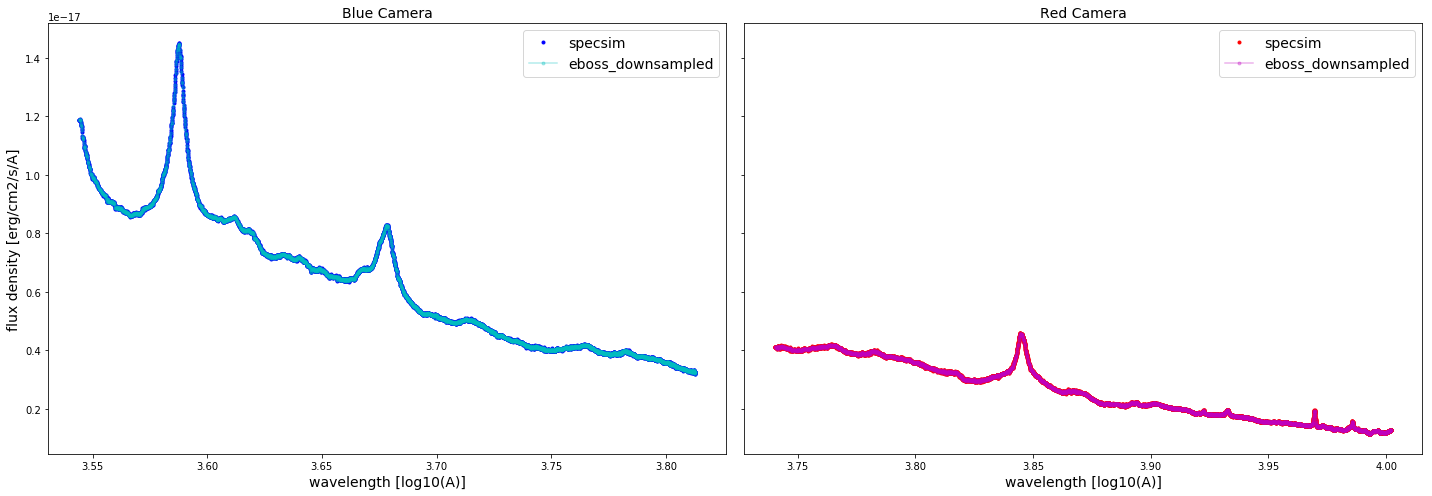

In [15]:
fig, axs = plt.subplots(1,2, figsize=(20,7), sharey=True)
axs = axs.ravel()

axs[0].plot(np.log10(b_wlen), b_flux, '.', c='b', label='specsim')
axs[0].plot(eboss_b_wlen, eboss_b_flux, '.-', alpha=0.3, c='c', label='eboss_downsampled')
axs[0].set_xlabel('wavelength [log10(A)]', fontsize=fs)
axs[0].set_ylabel('flux density [erg/cm2/s/A]', fontsize=fs)
axs[0].set_title('Blue Camera', fontsize=fs)
axs[0].legend(fontsize=fs)

axs[1].plot(np.log10(r_wlen), r_flux, '.', c='r', label='specsim')
axs[1].plot(eboss_r_wlen, eboss_r_flux, '.-', alpha=0.3, c='m', label='eboss_downsampled')
axs[1].set_xlabel('wavelength [log10(A)]', fontsize=fs)
axs[1].set_title('Red Camera', fontsize=fs)
axs[1].legend(fontsize=fs)

plt.tight_layout()
plt.show()

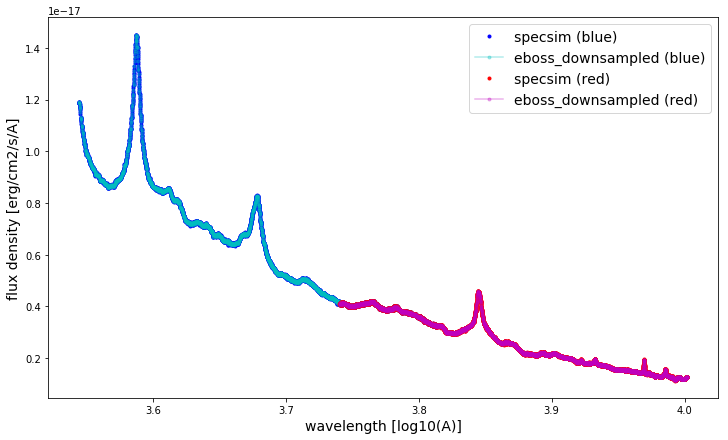

In [16]:
plt.figure(figsize=(12,7))
plt.plot(np.log10(b_wlen), b_flux, '.', c='b', label='specsim (blue)')
plt.plot(eboss_b_wlen, eboss_b_flux, '.-', alpha=0.3, c='c', label='eboss_downsampled (blue)')
plt.plot(np.log10(r_wlen), r_flux, '.', c='r', label='specsim (red)')
plt.plot(eboss_r_wlen, eboss_r_flux, '.-', alpha=0.3, c='m', label='eboss_downsampled (red)')
plt.xlabel('wavelength [log10(A)]', fontsize=fs)
plt.ylabel('flux density [erg/cm2/s/A]', fontsize=fs)
plt.legend(fontsize=fs)
plt.show()

In [17]:
red_output.colnames

['wavelength',
 'num_source_electrons',
 'num_sky_electrons',
 'num_dark_electrons',
 'read_noise_electrons',
 'random_noise_electrons',
 'variance_electrons',
 'flux_calibration',
 'observed_flux',
 'flux_inverse_variance']

In [18]:
path = '/Users/belaabolfathi/Documents/repos/specsim-for-eboss/'

In [19]:
b_wave_out = np.load(path+'mean_eboss_wlen_blue.npy')
r_wave_out = np.load(path+'mean_eboss_wlen_red.npy')

In [20]:
eboss_b_wlen, eboss_b_column = downsample_to_eboss(b_wave_out, b_wlen, blue_output['num_source_electrons'])

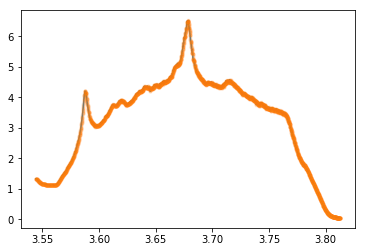

In [21]:
plt.plot(eboss_b_wlen, eboss_b_column)
plt.plot(np.log10(b_wlen), blue_output['num_source_electrons'], '.', alpha=0.1)
plt.show()

In [22]:
eboss_r_wlen, eboss_r_column = downsample_to_eboss(r_wave_out, r_wlen, red_output['num_source_electrons'])

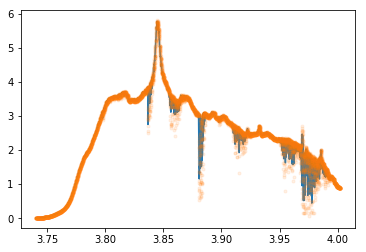

In [23]:
plt.plot(eboss_r_wlen, eboss_r_column)
plt.plot(np.log10(r_wlen), red_output['num_source_electrons'], '.', alpha=0.1)
plt.show()